In [8]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import yaml

check_sum_length = 5

# n_samples / sample_rate = duration in seconds
def create_sin_wave(freq, n_samples=44100, sample_rate=44100, amplitude=10000,
        save_to_file=None, graph=True):
    x = np.arange(n_samples)
    y = amplitude * np.sin(2 * np.pi * freq * x / sample_rate)
    if graph:
        plt.plot(y)
        plt.xlim(0, 512)
    if save_to_file is not None:
        output_array = y.astype(np.int16)
        wavfile.write(save_to_file, sample_rate, output_array)
    else:
        return y.astype(np.int16)

def get_signal(data_seq, sample_size=1024, write_to_file=None):
    tot_signal = list()
    for i in data_seq:
        if i == 0:
            signal = create_sin_wave(18 * 1000, n_samples=1024, graph=False)
        else:
            signal = create_sin_wave(19 * 1000, n_samples=1024, graph=False)
        tot_signal.extend(signal)
    print('generated signal of length {}'.format(len(tot_signal)))
    if write_to_file is not None:
        wavfile.write(write_to_file, 44100, np.array(tot_signal))
    return np.array(tot_signal).astype(np.int16)

# if output_length > music: the resulting signal conforms to music_length
# if output_length > data_signal: data_signal will be repeated to fit output_length
# all units here are in terms of number of samples points
def mix_with_music(data_signal, music_name, output_length=2*44100,    # use output_length of -1 for no trimming
                   # Note that 1024 * 5 means we will wait for 5 FFT intervals before
                   # attempting to transmit the next data sequence
                   start_delay=1024 * 5,
                   to_mono=True, graph=False,write_to_file=None):
    # 1. Extract Music Signals
    fs, data =  wavfile.read(music_name)
    if output_length == -1:
        output_length = len(data)
    music_signal = data[:output_length]
    if to_mono:
        music_signal = np.mean(music_signal, axis=1).astype(np.int16)

    # 2. Repeat + Pad Data Signals
    # if we can't fit data into music for kth time, it's ok to leave it as k - 1
    repeat_num = int(np.floor(output_length / (start_delay + len(data_signal))))
    # use music signal as base
    expanded_data_signal = []
    print('output repeates data signal {} times ({:.3f})'.format(repeat_num, output_length / (start_delay + len(data_signal))))
    for _ in range(repeat_num):
        expanded_data_signal.extend(list(np.zeros(start_delay, dtype=np.int16)))
        expanded_data_signal.extend(data_signal)
    # add zero paddings to match size of data and music
    while len(expanded_data_signal) < output_length:
        expanded_data_signal.append(0)

    # 3. Data + Music
    new_signal = np.array(expanded_data_signal, dtype=np.int16) + music_signal

    if write_to_file is not None:
        wavfile.write(write_to_file, 44100, new_signal)

    if graph:
        plt.subplot(1, 2, 1)
        plt.plot(music_signal)
        plt.title('before')
        plt.subplot(1, 2, 2)
        plt.plot(new_signal)
        plt.title('after')
        plt.tight_layout()

    return new_signal

def binary2int(binary_array):
    binary_string = ''
    for i in binary_array:
        binary_string += str(i)
    return int(binary_string, 2)

def binary_array2string(binary_array):
    binary_string = ''
    for i in binary_array:
        binary_string += str(i)
    return binary_string

def get_check_sum(data_seq, size=check_sum_length):
    data_code = binary2int(data_seq)
    check_sum_int = data_code % (2**check_sum_length)
    check_sum_array = [int(i) for i in bin(check_sum_int)[2:]]
    while (len(check_sum_array) < check_sum_length):
        check_sum_array.insert(0, 0)
    return check_sum_array

def mix_with_music_for_sequences(data_signals, music_name, start_delay=1024 * 15, to_mono=True, write_to_file=None, graph=False):
    # 1. Extract Music Signals
    fs, music_signal =  wavfile.read(music_name)
    if to_mono:
        music_signal = np.mean(music_signal, axis=1).astype(np.int16)

    # 2. Data + pad + music
    combined_data_signals = []
    for curr_data_signal in data_signals:
        combined_data_signals.extend(list(np.zeros(start_delay, dtype=np.int16)))
        combined_data_signals.extend(curr_data_signal)
    # 2.1 add a little buffer in the end
    combined_data_signals.extend(list(np.zeros(start_delay, dtype=np.int16)))
    print('combined data signal size: ', len(combined_data_signals))
    print('trimming music signal to the first {} seconds'.format(len(combined_data_signals) / 44100))
    
    new_signal = np.array(combined_data_signals) + music_signal[:len(combined_data_signals)]
    if write_to_file is not None:
        wavfile.write(write_to_file, 44100, new_signal)

    if graph:
        plt.subplot(1, 2, 1)
        plt.plot(music_signal)
        plt.title('before')
        plt.subplot(1, 2, 2)
        plt.plot(new_signal)
        plt.title('after')
        plt.tight_layout()

    return new_signal



## Channel Selection with Constant Waves

In [10]:
for i in range(18 * 1000, 20 * 1000 + 1, 500):
    create_sin_wave(i, n_samples=44100 * 2, save_to_file= "eval_output/const_{}.wav".format(i), graph=False)

In [7]:
18500 / 44100 * 1024

429.5691609977324

In [12]:
# file_names = ['18kHz.yaml']

with open('eval_result/channel_select.yaml', 'r') as f:
    cs_result = yaml.load(f)

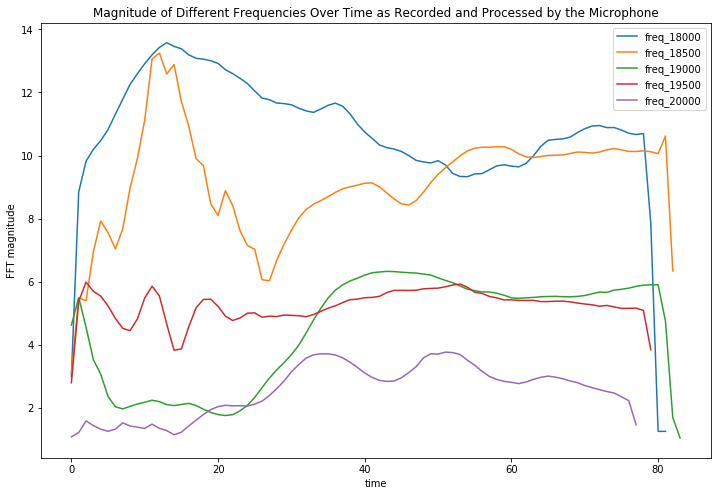

In [28]:
plt.figure(figsize=(12,8))
plt.xlabel('time')
plt.ylabel('FFT magnitude')
plt.title('Magnitude of Different Frequencies Over Time as Recorded and Processed by the Microphone')
for i in range(18 * 1000, 20 * 1000 + 1, 500):
    plt.plot(cs_result['freq_{}'.format(i)], label = 'freq_{}'.format(i))
plt.legend()
plt.savefig('eval_output/channel_selection.png')

## Error Rate & Data Rate vs Distnace

In [25]:
n_test_samples = 6
all_test_data = []
for _ in range(n_test_samples):
    all_test_data.append(np.random.choice([0, 1], 26))
all_test_data

[array([1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
        0, 1, 0, 1]),
 array([1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 0]),
 array([0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
        0, 0, 0, 0]),
 array([0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
        1, 1, 0, 0]),
 array([1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 0]),
 array([1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0])]

In [5]:
preamble = [0, 1, 0, 1, 1, 0]
all_test_data = [np.array([1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
        0, 1, 0, 1]),
 np.array([1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 0]),
 np.array([0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
        0, 0, 0, 0]),
 np.array([0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
        1, 1, 0, 0]),
 np.array([1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 0]),
 np.array([1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0])]

full_test_signals = []
for curr_data in all_test_data:
    curr_full = list(preamble) + list(curr_data) + list(get_check_sum(curr_data))
    print('check sum is ', get_check_sum(curr_data))
    full_test_signals.append(get_signal(curr_full))
full_test_signals

check sum is  [1, 0, 1, 0, 1]
generated signal of length 37888
check sum is  [0, 1, 0, 1, 0]
generated signal of length 37888
check sum is  [1, 0, 0, 0, 0]
generated signal of length 37888
check sum is  [0, 1, 1, 0, 0]
generated signal of length 37888
check sum is  [1, 1, 1, 1, 0]
generated signal of length 37888
check sum is  [1, 0, 0, 0, 0]
generated signal of length 37888


[array([    0,  5455, -9144, ..., -6536,  9115, -9999], dtype=int16),
 array([    0,  5455, -9144, ..., -9953,  7818, -3151], dtype=int16),
 array([    0,  5455, -9144, ..., -9953,  7818, -3151], dtype=int16),
 array([    0,  5455, -9144, ..., -9953,  7818, -3151], dtype=int16),
 array([    0,  5455, -9144, ..., -9953,  7818, -3151], dtype=int16),
 array([    0,  5455, -9144, ..., -9953,  7818, -3151], dtype=int16)]

combined data signal size:  334848
trimming music signal to the first 7.592925170068027 seconds


array([-1439, -1446, -1444, ...,  -942, -1048, -1141], dtype=int16)

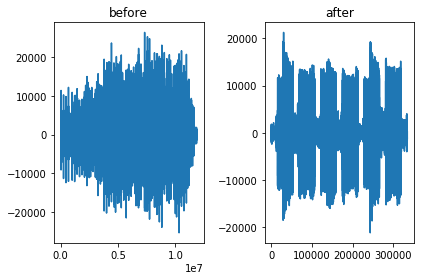

In [20]:
song_name = "original_songs/cop_cut.wav"

mix_with_music_for_sequences(full_test_signals, song_name, write_to_file='eval_output/error_data_rate_cop.wav', graph=True)

In [28]:
with open('eval_result/result_vs_dist_cop.yaml', 'r') as f:
    cop_result = yaml.load(f)
with open('eval_result/result_vs_dis_sf.yaml', 'r') as f:
    sf_result = yaml.load(f)

In [38]:
a = list(cop_result['dist_50'][0].values())
np.array(a) == np.array(all_test_data[0])

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True]])

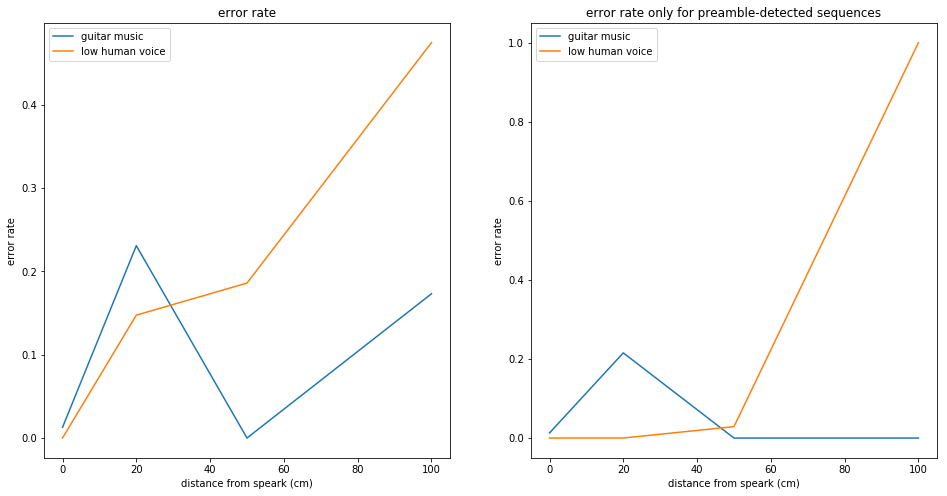

In [53]:
distances = [0, 20, 50, 100]
samples_per_distance = 6

def average_accu(data_seq, expected_seq):
    return np.count_nonzero(np.array(data_seq) == np.array(expected_seq)) / len(expected_seq)

sf_accu = []
sf_accu_skip_miss = []
for i in distances:
    curr_accus = []
    curr_accus_skip_miss = []
    for j in range(samples_per_distance):
        curr_result = list(sf_result['dist_{}'.format(i)][j].values())
        curr_accus.append(average_accu(curr_result, all_test_data[j]))
        if np.sum(curr_result) != 0:
            curr_accus_skip_miss.append(average_accu(curr_result, all_test_data[j]))
    sf_accu.append(np.mean(curr_accus))
    sf_accu_skip_miss.append(np.mean(curr_accus_skip_miss))

cop_accu = []
cop_accu_skip_miss = []
for i in distances:
    curr_accus = []
    curr_accus_skip_miss = []
    for j in range(samples_per_distance):
        curr_result = list(cop_result['dist_{}'.format(i)][j].values())
        curr_accus.append(average_accu(curr_result, all_test_data[j]))
        if np.sum(curr_result) != 0:
            curr_accus_skip_miss.append(average_accu(curr_result, all_test_data[j]))
    cop_accu.append(np.mean(curr_accus))
    if len(curr_accus_skip_miss) != 0:
        cop_accu_skip_miss.append(np.mean(curr_accus_skip_miss))
    else:
        cop_accu_skip_miss.append(0)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
ax1.set_title('error rate')
ax1.plot(distances, 1 - np.array(sf_accu), label='guitar music')
ax1.plot(distances, 1 - np.array(cop_accu), label='low human voice')
ax1.set_xlabel('distance from speark (cm)')
ax1.set_ylabel('error rate')
ax1.legend()

ax2.set_title('error rate only for preamble-detected sequences')
ax2.plot(distances, 1 - np.array(sf_accu_skip_miss), label='guitar music')
ax2.plot(distances, 1 - np.array(cop_accu_skip_miss), label='low human voice')
ax2.set_xlabel('distance from speark (cm)')
ax2.set_ylabel('error rate')
ax2.legend()
plt.savefig('eval_result/error_rate.png')

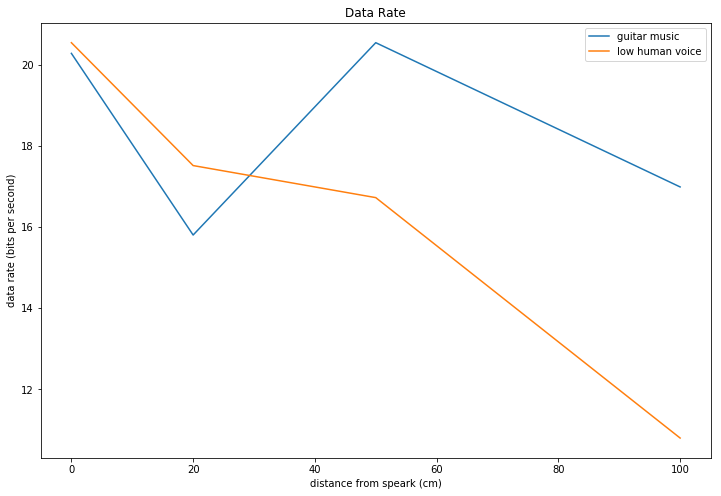

In [58]:
perfect_data_rate = 26 * 6 / 7.592925170068027
plt.figure(figsize=(12,8))
plt.plot(distances, np.array(sf_accu) * perfect_data_rate, label='guitar music')
plt.plot(distances, np.array(cop_accu) * perfect_data_rate, label='low human voice')
plt.legend()
plt.title('Data Rate')
plt.xlabel('distance from speark (cm)')
plt.ylabel('data rate (bits per second)')
plt.savefig('eval_result/data_rate.png')

In [21]:
np.zeros(26, dtype=np.int16)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int16)